<h1 align="center"> INF6804 Lab 2: BRIEF descriptor </h1>
<br>
<h3 align="center"> Daniel Wang, Oumayma Messoussi </h3>
<br>

In [ ]:
import numpy as np
from skimage import data, io
from skimage.feature import BRIEF, corner_peaks, corner_fast, match_descriptors, plot_matches
import matplotlib.pyplot as plt
from sgm import *
import glob

### BRIEF descriptor on KITTI dataset

In [ ]:
# source: https://github.com/gabilodeau/INF6804/blob/master/Descripteur%20BRIEF.ipynb

img1 = io.imread('KITTI/data_scene_flow/training/image_2/000000_10.png', as_gray= True)
img2 = io.imread('KITTI/data_scene_flow/training/image_2/000000_11.png', as_gray= True)
plt.imshow(img2, cmap='gray')
plt.show()

# extracting key points

kps1 = corner_peaks(corner_fast(img1), min_distance=5)
kps2 = corner_peaks(corner_fast(img2), min_distance=5)

# BRIEF descriptor

extractor = BRIEF(descriptor_size=128, patch_size=5, mode='normal')

extractor.extract(img1, kps1)
descriptor1 = extractor.descriptors
extractor.extract(img2, kps2)
descriptor2 = extractor.descriptors

# matching

matches = match_descriptors(descriptor1, descriptor2, cross_check=True)

# visualization

fig = plt.figure(figsize=(36, 20)) 
ax0 = plt.subplot()
plot_matches(ax0, img1, img2, kps1, kps2, matches)
ax0.axis('off')
ax0.set_title("Image1 vs. Image2")
plt.show()

In [ ]:
plt.imshow(descriptor1, cmap='gray')
plt.show()

### SGM disparity estimation

In [144]:
# Source: https://github.com/beaupreda/semi-global-matching

def compute_costs(left, right, parameters, save_images):
    """
    first step of the sgm algorithm
    :param left: left descriptor.
    :param right: right descriptor.
    :param parameters: structure containing parameters of the algorithm.
    :param save_images: whether to save census images or not.
    :return: H x W x D array with the matching costs.
    """
    
    max_disparity=64
    P1=5
    P2=70
    csize=(7, 7)
    bsize=(3, 3)
    
    assert left.shape[0] == right.shape[0] and left.shape[1] == right.shape[1], 'left & right must have the same shape.'
    assert parameters.max_disparity > 0, 'maximum disparity must be greater than 0.'

    height = left.shape[0]
    width = left.shape[1]
    cheight = parameters.csize[0]
    cwidth = parameters.csize[1]
    y_offset = int(cheight / 2)
    x_offset = int(cwidth / 2)
    disparity = parameters.max_disparity

    left_census_values = left
    right_census_values = right

    print('\tComputing cost volumes...', end='')
    sys.stdout.flush()
    dawn = t.time()
    left_cost_volume = np.zeros(shape=(height, width, disparity), dtype=np.uint32)
    right_cost_volume = np.zeros(shape=(height, width, disparity), dtype=np.uint32)
    lcensus = np.zeros(shape=(height, width), dtype=np.int64)
    rcensus = np.zeros(shape=(height, width), dtype=np.int64)
    for d in range(0, disparity):
        rcensus[:, (x_offset + d):(width - x_offset)] = right_census_values[:, x_offset:(width - d - x_offset)]
        left_xor = np.int64(np.bitwise_xor(np.int64(left_census_values), rcensus))
        left_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(left_xor == 0):
            tmp = left_xor - 1
            mask = left_xor != 0
            left_xor[mask] = np.bitwise_and(left_xor[mask], tmp[mask])
            left_distance[mask] = left_distance[mask] + 1
        left_cost_volume[:, :, d] = left_distance

        lcensus[:, x_offset:(width - d - x_offset)] = left_census_values[:, (x_offset + d):(width - x_offset)]
        right_xor = np.int64(np.bitwise_xor(np.int64(right_census_values), lcensus))
        right_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(right_xor == 0):
            tmp = right_xor - 1
            mask = right_xor != 0
            right_xor[mask] = np.bitwise_and(right_xor[mask], tmp[mask])
            right_distance[mask] = right_distance[mask] + 1
        right_cost_volume[:, :, d] = right_distance

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_cost_volume, right_cost_volume

In [168]:
def get_recall(disparity, gt, disp):
    """
    computes the recall of the disparity map.
    :param disparity: disparity image.
    :param gt: path to ground-truth image.
    :param args: program arguments.
    :return: rate of correct predictions.
    """
    gt = np.float32(cv2.imread(gt, cv2.IMREAD_GRAYSCALE))
    gt = gt[1:gt.shape[0]-1, 1:gt.shape[1]-1]
    gt = np.int16(gt / 255.0 * float(disp))
    disparity = np.int16(np.float32(disparity) / 255.0 * float(disp))
    correct = np.count_nonzero(np.abs(disparity - gt) <= 3)
    return float(correct) / gt.size

In [169]:
def sgm(descriptorL, descriptorR, basename, gt1, gt2):
    """
    main function applying the semi-global matching algorithm.
    :return: void.
    """

    disparity = 64
    save_images = False
    evaluation = True
    output_name = basename
    left_gt_name = gt1
    right_gt_name = gt2

    dawn = t.time()

    parameters = Parameters(max_disparity=disparity, P1=10, P2=120, csize=(7, 7), bsize=(3, 3))
    paths = Paths()

    print('\nStarting cost computation...')
    left_cost_volume, right_cost_volume = compute_costs(descriptorL, descriptorR, parameters, save_images)

    print('\nStarting left aggregation computation...')
    left_aggregation_volume = aggregate_costs(left_cost_volume, parameters, paths)
    print('\nStarting right aggregation computation...')
    right_aggregation_volume = aggregate_costs(right_cost_volume, parameters, paths)

    print('\nSelecting best disparities...')
    left_disparity_map = np.uint8(normalize(select_disparity(left_aggregation_volume), parameters))
    right_disparity_map = np.uint8(normalize(select_disparity(right_aggregation_volume), parameters))
    if save_images:
        cv2.imwrite('left_disp_map_no_post_processing.png', left_disparity_map)
        cv2.imwrite('right_disp_map_no_post_processing.png', right_disparity_map)

    print('\nApplying median filter...')
    left_disparity_map = cv2.medianBlur(left_disparity_map, parameters.bsize[0])
    right_disparity_map = cv2.medianBlur(right_disparity_map, parameters.bsize[0])
    cv2.imwrite(f'left_disp_{output_name}', left_disparity_map)
    cv2.imwrite(f'right_disp_{output_name}', right_disparity_map)

    if evaluation:
        print('\nEvaluating left disparity map...')
        left_recall = get_recall(left_disparity_map, left_gt_name, disparity)
        print('\tRecall left= {:.2f}%'.format(left_recall * 100.0))
        print('\nEvaluating right disparity map...')
        right_recall = get_recall(right_disparity_map, right_gt_name, disparity)
        print('\tRecall right= {:.2f}%'.format(right_recall * 100.0))

    dusk = t.time()
    print('\nFin.')
    print('\nTotal execution time = {:.2f}s'.format(dusk - dawn))
    
    return left_disparity_map, right_disparity_map, left_recall, right_recall

(462520, 8)
(462520, 8)
(373, 1240)
computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.13s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 33.87s)
	Processing paths south-east and north-west...	(done in 78.13s)
	Processing paths south and north...	(done in 76.87s)
	Processing paths south-west and north-east...	(done in 79.25s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 77.40s)
	Processing paths south-east and north-west...	(done in 78.25s)
	Processing paths south and north...	(done in 78.11s)
	Processing paths south-west and north-east...	(done in 78.37s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 81.65%

Evaluating right disparity map...
	Recall right= 82.24%

Fin.

Total execution time = 583.66s


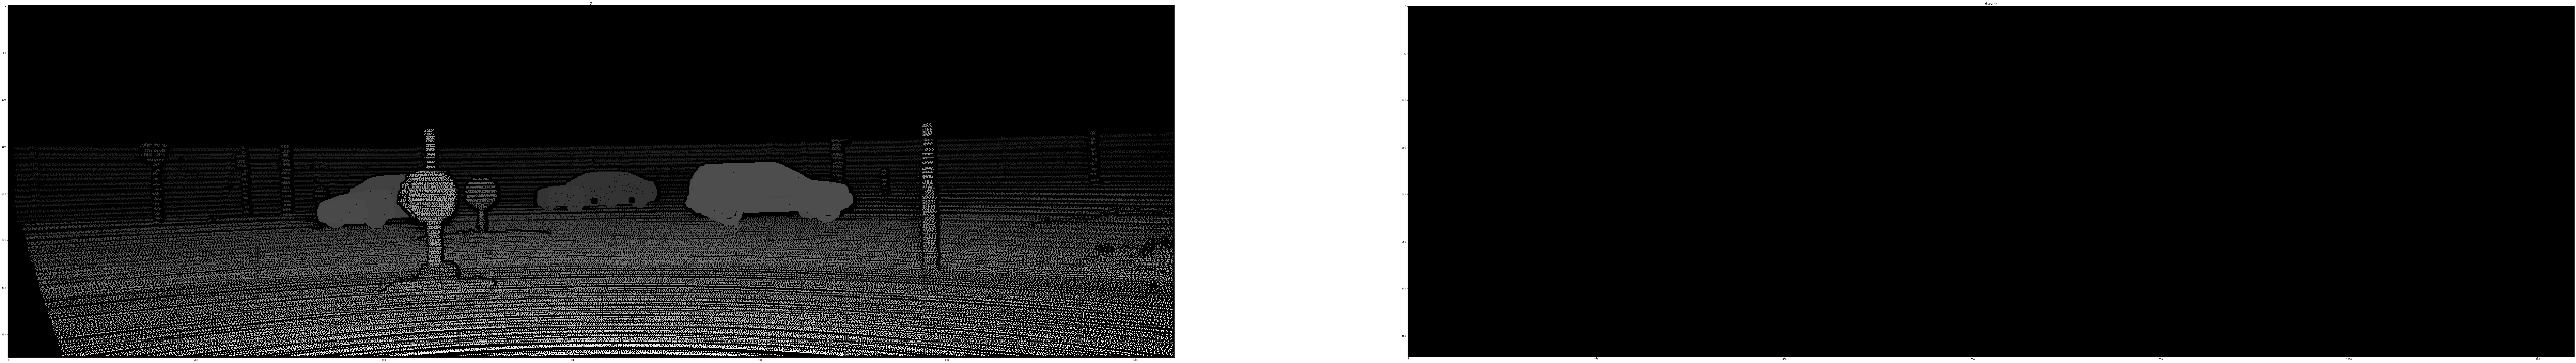

(462520, 8)
(462520, 8)
(373, 1240)
computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.69s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 76.59s)
	Processing paths south-east and north-west...	(done in 78.50s)
	Processing paths south and north...	(done in 77.46s)
	Processing paths south-west and north-east...	(done in 78.37s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 77.13s)
	Processing paths south-east and north-west...	(done in 78.13s)
	Processing paths south and north...	(done in 77.56s)
	Processing paths south-west and north-east...	(done in 78.51s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 89.56%

Evaluating right disparity map...
	Recall right= 89.60%

Fin.

Total execution time = 625.81s


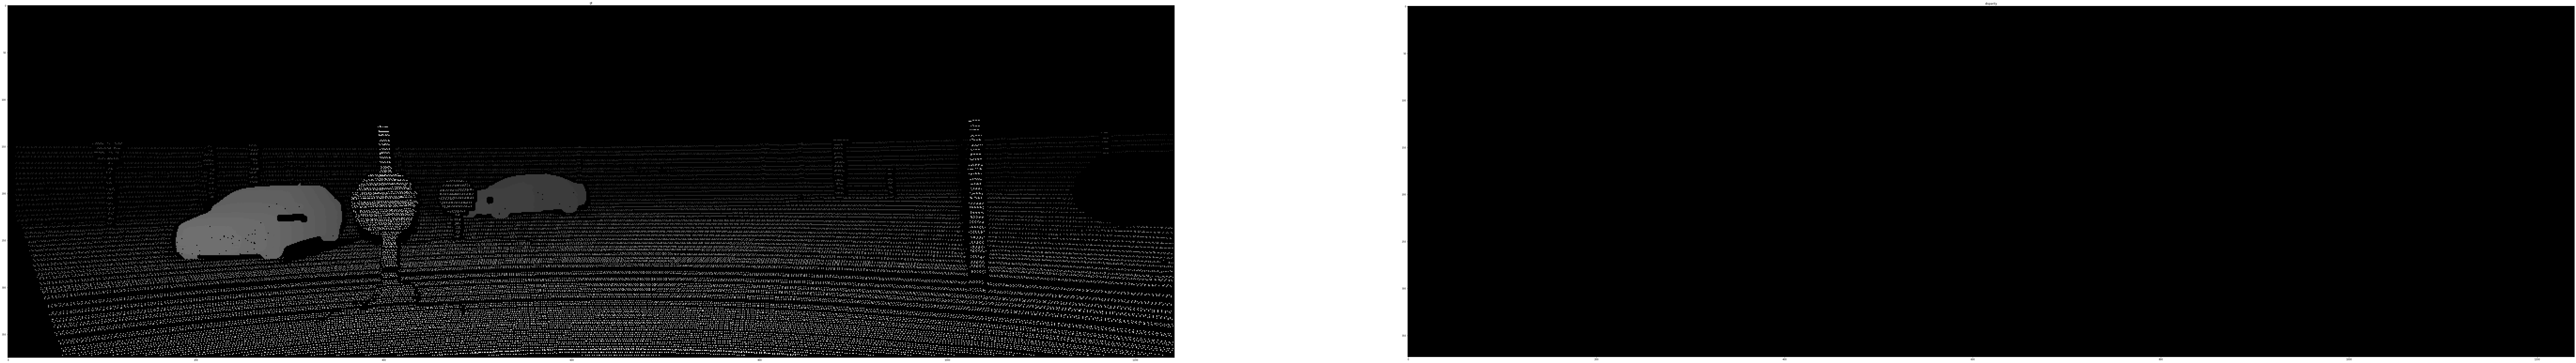

(462520, 8)
(462520, 8)
(373, 1240)
computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.67s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 76.72s)
	Processing paths south-east and north-west...	(done in 78.34s)
	Processing paths south and north...	(done in 77.33s)
	Processing paths south-west and north-east...	(done in 78.48s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 76.41s)
	Processing paths south-east and north-west...	(done in 78.22s)
	Processing paths south and north...	(done in 77.35s)
	Processing paths south-west and north-east...	(done in 78.57s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 87.97%

Evaluating right disparity map...
	Recall right= 87.98%

Fin.

Total execution time = 624.94s


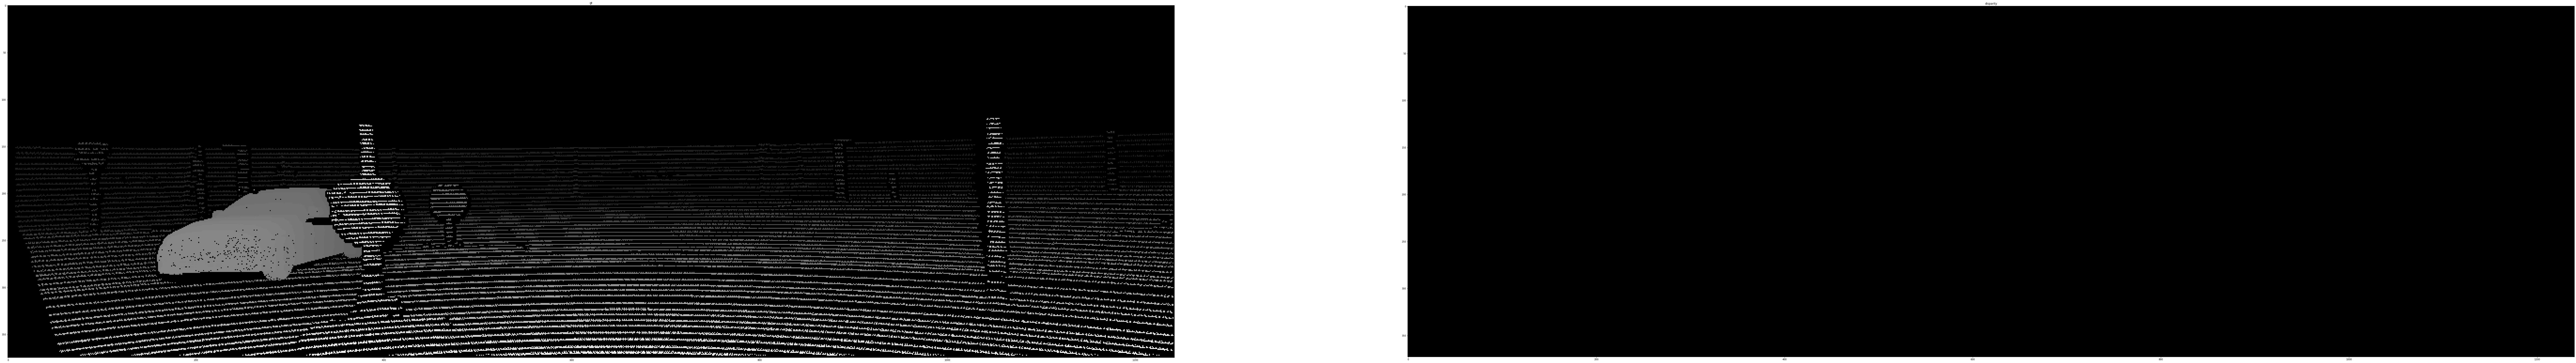

(462520, 8)
(462520, 8)
(373, 1240)
computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.69s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 76.76s)
	Processing paths south-east and north-west...	(done in 78.48s)
	Processing paths south and north...	(done in 77.06s)
	Processing paths south-west and north-east...	(done in 79.08s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 76.62s)
	Processing paths south-east and north-west...	(done in 78.40s)
	Processing paths south and north...	(done in 77.32s)
	Processing paths south-west and north-east...	(done in 78.37s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 84.56%

Evaluating right disparity map...
	Recall right= 85.22%

Fin.

Total execution time = 625.66s


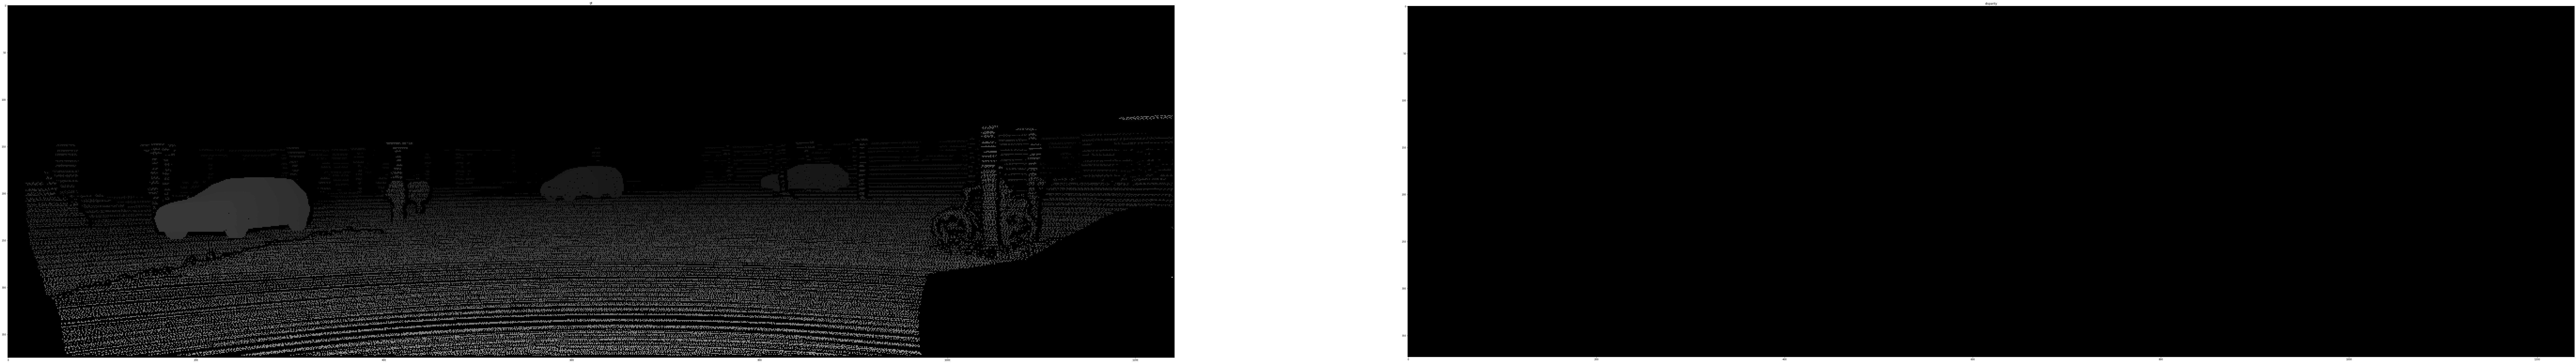

(462520, 8)
(462520, 8)
(373, 1240)
computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.70s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 76.33s)
	Processing paths south-east and north-west...	(done in 78.27s)
	Processing paths south and north...	(done in 77.36s)
	Processing paths south-west and north-east...	(done in 78.33s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 76.38s)
	Processing paths south-east and north-west...	(done in 78.33s)
	Processing paths south and north...	(done in 77.93s)
	Processing paths south-west and north-east...	(done in 78.26s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 83.20%

Evaluating right disparity map...
	Recall right= 83.44%

Fin.

Total execution time = 625.17s


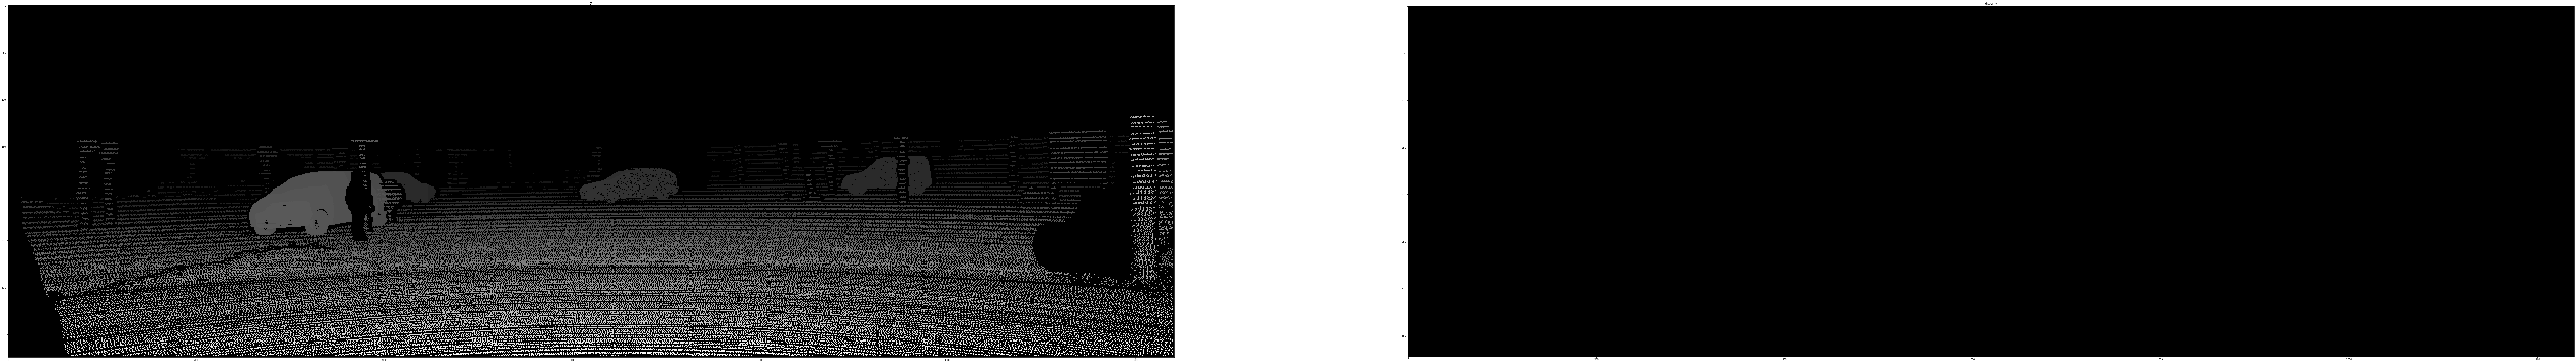

(462520, 8)
(462520, 8)
(373, 1240)
computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.70s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 76.48s)
	Processing paths south-east and north-west...	(done in 78.04s)
	Processing paths south and north...	(done in 77.11s)
	Processing paths south-west and north-east...	(done in 78.29s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 76.42s)
	Processing paths south-east and north-west...	(done in 77.97s)
	Processing paths south and north...	(done in 77.16s)
	Processing paths south-west and north-east...	(done in 78.09s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 83.18%

Evaluating right disparity map...
	Recall right= 83.27%

Fin.

Total execution time = 623.11s


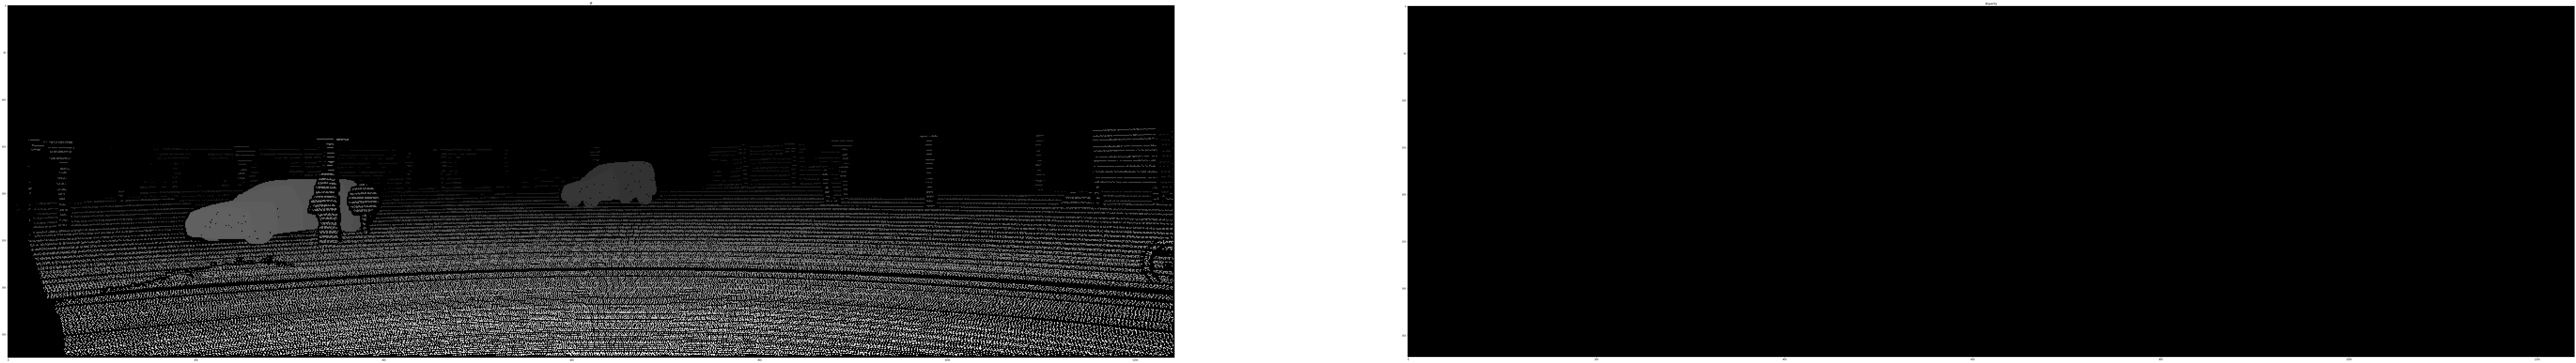

(462520, 8)
(462520, 8)
(373, 1240)
computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.69s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 76.21s)
	Processing paths south-east and north-west...	(done in 78.33s)
	Processing paths south and north...	(done in 77.12s)
	Processing paths south-west and north-east...	(done in 78.07s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 76.58s)
	Processing paths south-east and north-west...	(done in 78.00s)
	Processing paths south and north...	(done in 77.18s)
	Processing paths south-west and north-east...	(done in 78.19s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 83.95%

Evaluating right disparity map...
	Recall right= 83.97%

Fin.

Total execution time = 623.25s


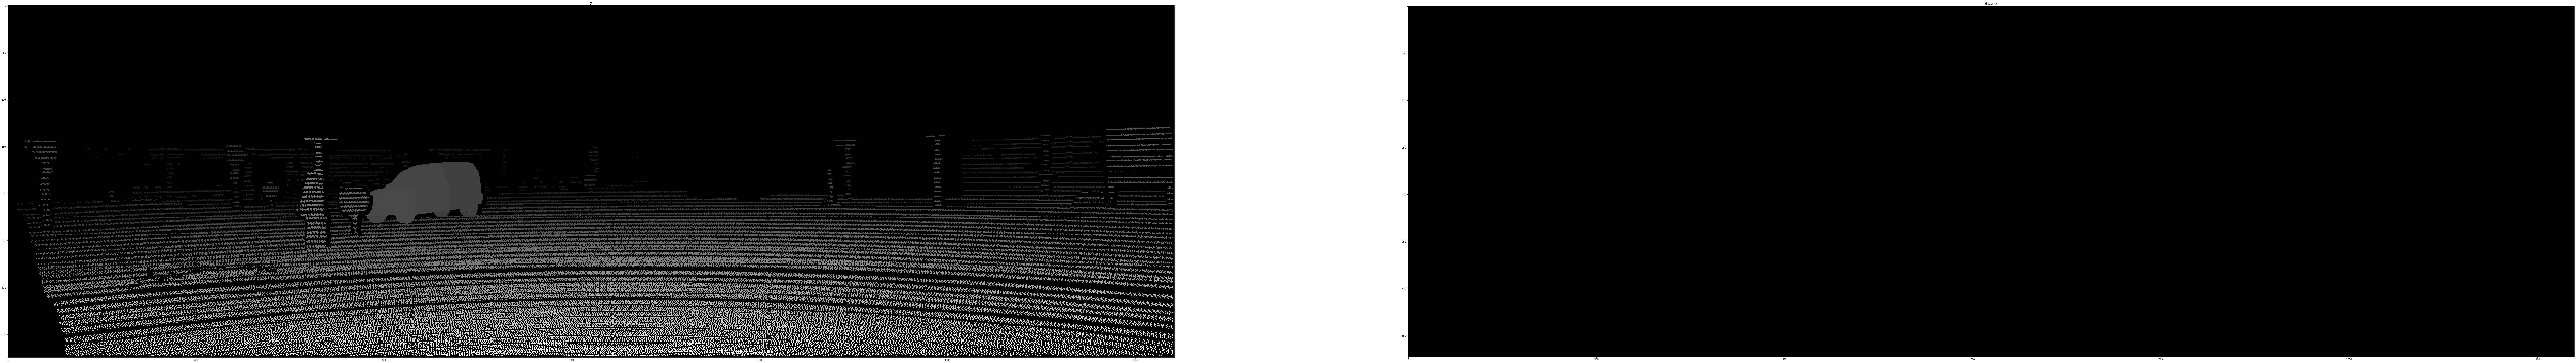

(462520, 8)
(462520, 8)
(373, 1240)
computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.69s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 76.16s)
	Processing paths south-east and north-west...	(done in 78.36s)
	Processing paths south and north...	(done in 77.08s)
	Processing paths south-west and north-east...	(done in 78.83s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 76.12s)
	Processing paths south-east and north-west...	(done in 78.15s)
	Processing paths south and north...	(done in 76.85s)
	Processing paths south-west and north-east...	(done in 78.20s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 86.08%

Evaluating right disparity map...
	Recall right= 87.35%

Fin.

Total execution time = 623.28s


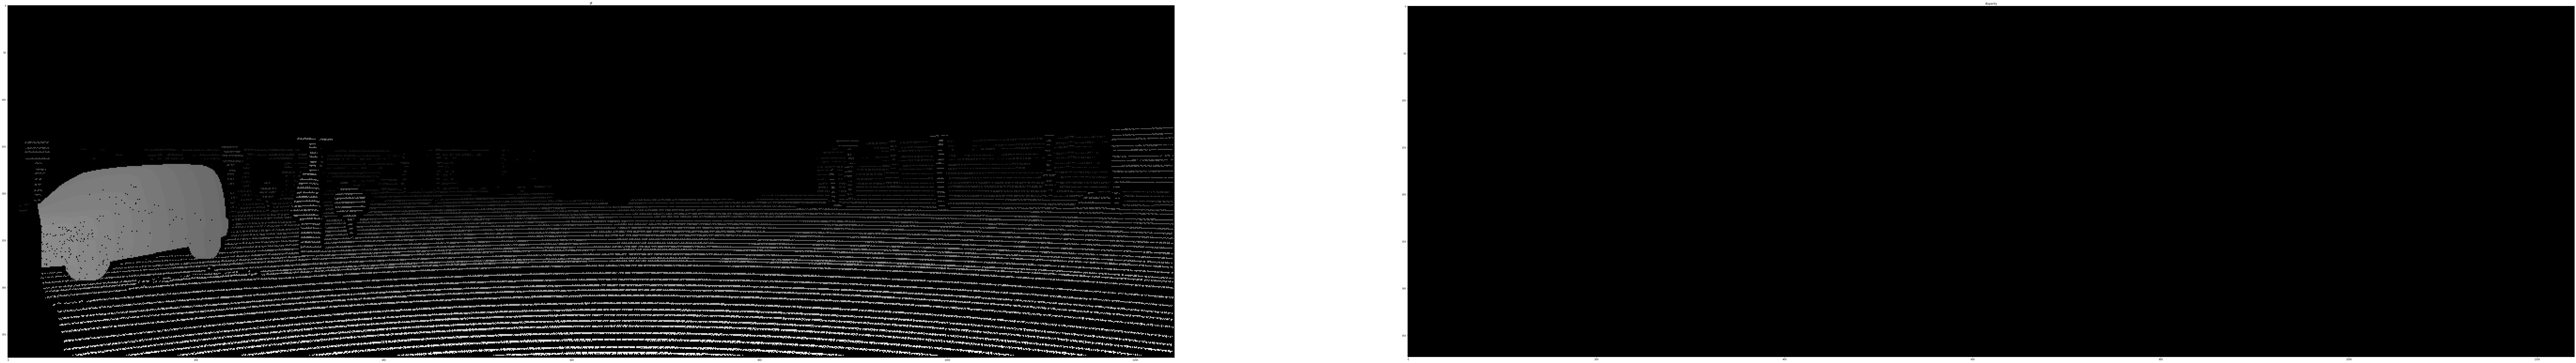

(462520, 8)
(462520, 8)
(373, 1240)
computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.70s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 76.30s)
	Processing paths south-east and north-west...	(done in 78.45s)
	Processing paths south and north...	(done in 76.86s)
	Processing paths south-west and north-east...	(done in 78.10s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 75.89s)
	Processing paths south-east and north-west...	(done in 78.31s)
	Processing paths south and north...	(done in 77.64s)
	Processing paths south-west and north-east...	(done in 78.15s)

Selecting best disparities...

Applying median filter...

Evaluating left disparity map...
	Recall left= 81.93%

Evaluating right disparity map...
	Recall right= 84.56%

Fin.

Total execution time = 623.65s


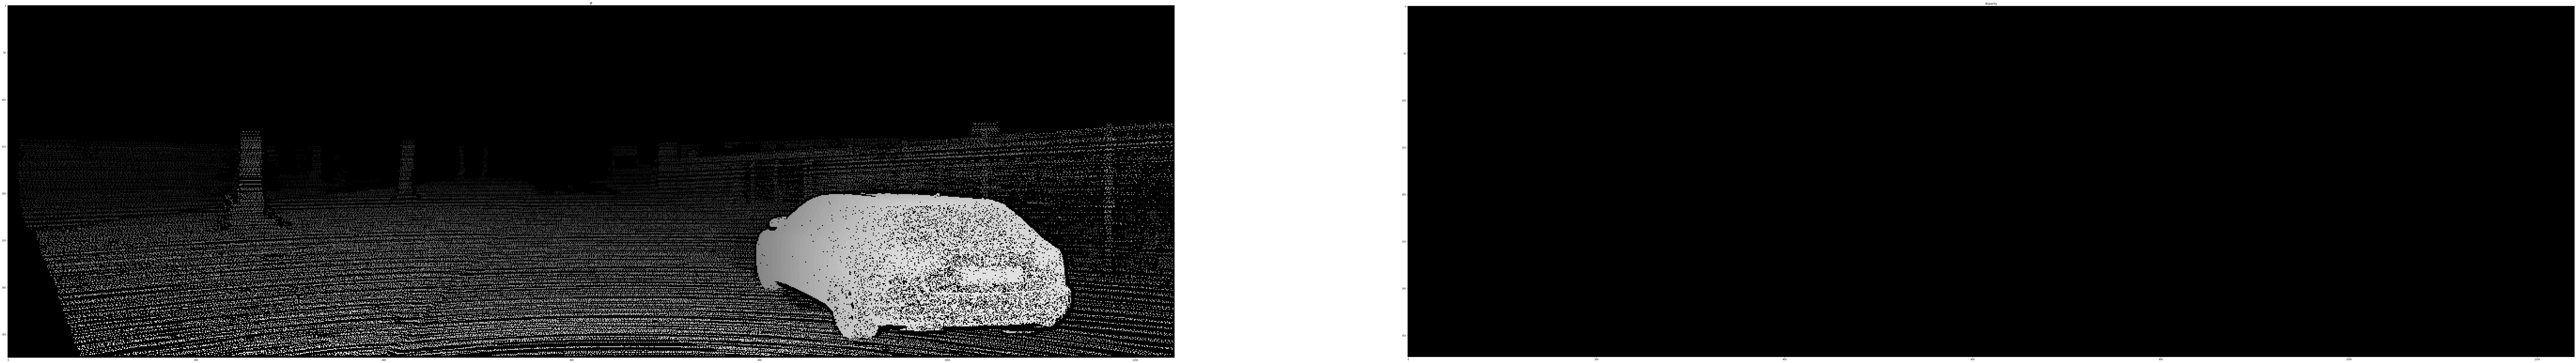

(462520, 8)
(462520, 8)
(373, 1240)
computing disparity...

Starting cost computation...
	Computing cost volumes...	(done in 1.68s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 76.48s)
	Processing paths south-east and north-west...	(done in 78.43s)
	Processing paths south and north...	(done in 77.06s)
	Processing paths south-west and north-east...	(done in 78.15s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 76.49s)
	Processing paths south-east and north-west...	(done in 78.34s)
	Processing paths south and north...

KeyboardInterrupt: 

In [170]:
# Source: http://timosam.com/python_opencv_depthimage

stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=160,     
    blockSize=1,
    P1=8 * 3 * 3 ** 2,
    P2=32 * 3 * 3 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

for image1, image2, gt1, gt2 in zip(glob.glob('KITTI/data_scene_flow/training/image_2/0000[1-2][0-9]_10.png'), 
                              glob.glob('KITTI/data_scene_flow/training/image_2/0000[1-2][0-9]_11.png'),
                              glob.glob('KITTI/data_scene_flow/training/disp_noc_0/0000[1-2][0-9]_10.png'),
                              glob.glob('KITTI/data_scene_flow/training/disp_noc_1/0000[1-2][0-9]_10.png')):
    
    imgL = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)
    gtL = cv2.imread(gt1, cv2.IMREAD_GRAYSCALE)
    gtR = cv2.imread(gt2, cv2.IMREAD_GRAYSCALE)
    
    # matrix indices to use as "key points"

    indicesL = np.zeros(((imgL.shape[0]-2)*(imgL.shape[1]-2), 2), dtype=np.int64)
    indicesR = np.zeros(((imgR.shape[0]-2)*(imgR.shape[1]-2), 2), dtype=np.int64)
    
    k = 0
    for i in range(1, imgL.shape[0]-1):
        for j in range(1, imgL.shape[1]-1):
            indicesL[k][0], indicesL[k][1] = i, j
            k += 1
    k = 0
    for i in range(1, imgR.shape[0]-1):
        for j in range(1, imgR.shape[1]-1):      
            indicesR[k][0], indicesR[k][1] = i, j
            k += 1

    # BRIEF descriptor

    extractor = BRIEF(descriptor_size=8, patch_size=3, mode='normal')
    
    extractor.extract(imgL, indicesL)
    descriptorL = extractor.descriptors
    extractor.extract(imgR, indicesR)
    descriptorR = extractor.descriptors

    print(descriptorL.shape)
    
    descL = np.ndarray((descriptorL.shape[0],1), dtype=np.int64)
    descR = np.ndarray((descriptorR.shape[0],1), dtype=np.int64)

    for i in range(descriptorL.shape[0]):
        descriptorL[i, 0] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
        descL[i] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
        
    for i in range(descriptorR.shape[0]):
        descriptorR[i, 0] = descriptorR[i].dot(2**np.arange(descriptorR[i].size)[::-1])
        descL[i] = descriptorL[i].dot(2**np.arange(descriptorL[i].size)[::-1])
    
    print(descriptorL.shape)
    
    descriptorL = descL.reshape((373, 1240))
    descriptorR = descL.reshape((373, 1240))
    
    print(descriptorL.shape)

    # SGM matching
    
    print('computing disparity...')
    
    left_disparity_map, right_disparity_map, left_recall, right_recall = sgm(descriptorL, descriptorR, image1.split('/')[3].split('\\')[1], gt1, gt2)
    #disparity = stereo.compute(descriptorL.astype(np.uint8), descriptorR.astype(np.uint8)).astype(np.float32)/16
    #disparity = cv2.normalize(src=disparity, dst=disparity, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    
    # visualization
    
#     fig = plt.figure(figsize=(200, 200))
            
#     x = fig.add_subplot(1,2, 1)
#     x.set_title('imgL')
#     plt.imshow(imgL, cmap='gray')

#     y = fig.add_subplot(1,2, 2)
#     y.set_title('imgR')
#     plt.imshow(imgR, cmap='gray')
    
#     plt.show()
    
    fig = plt.figure(figsize=(200, 200))
    
    x = fig.add_subplot(1,2, 1)
    x.set_title('gt')
    plt.imshow(gtL, cmap='gray')

    y = fig.add_subplot(1,2, 2)
    y.set_title('disparity')
    plt.imshow(left_disparity_map, cmap='gray')

    plt.show()

In [175]:
np.max(left_disparity_map)

0